In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
n = np.array(data.n)
b = np.array(data.b)
s = np.array(data.s)
N = n.shape[0]
data

,n,b,s
0,105,100,10


In [4]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [5]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [6]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [7]:
# The observed LnQ
Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected=False)
Qobs

-0.0151377589082351

In [8]:
def Sampler(mu, Ntoys = int(2e4)):

    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
        q1[i] = GetJointLnQ(GetLnQ, mu, Null = False) #H1
    
    return q0,q1

In [9]:
q0,q1 =  Sampler(1.)

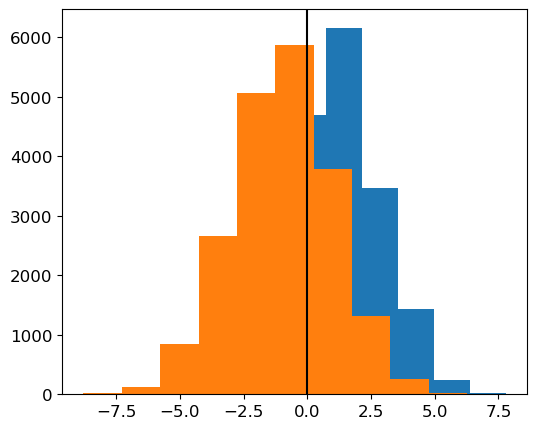

In [10]:
plt.hist(q0)
plt.hist(q1)
plt.axvline(x=Qobs,color='k')
#plt.yscale('log')

In [11]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [12]:
p0 = GetPValue(q0,Qobs,Null = True)
p1 = GetPValue(q1,Qobs,Null = False)
print(p0,p1)

0.3213 0.33775


In [13]:
Clsb = p1
Clb = 1 - p0
print(Clb,Clsb)

0.6787000000000001 0.33775


In [14]:
Cls = Clsb/Clb
Cls

0.49764255193752754

In [15]:
mu = np.linspace(0.5,3,20)

In [16]:
# p-value scan
def GetCls(mu,Expected=False):

    p_value = np.zeros_like(mu)

    for i in tqdm(range(mu.shape[0])):

        Qobs = GetObsJointLnQ(GetLnQ,mu[i],Expected)
        q0,q1 = Sampler(mu[i])

        p0 = GetPValue(q0,Qobs,Null = True)
        p1 = GetPValue(q1,Qobs,Null = False)

        Clb = 1 - p0
        Clsb = p1
        
        Clsb = Clsb/Clb

        p_value[i] = Clsb

    return p_value

In [17]:
Op_value = GetCls(mu,Expected=False)
Ep_value = GetCls(mu,Expected=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


In [18]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [19]:
ExpectedLimit = GetUpperLimit(mu,Ep_value)
ExpectedLimit

2.1768806882147387

In [20]:
ObservedLimit = GetUpperLimit(mu,Op_value)
ObservedLimit

2.5612792297313822

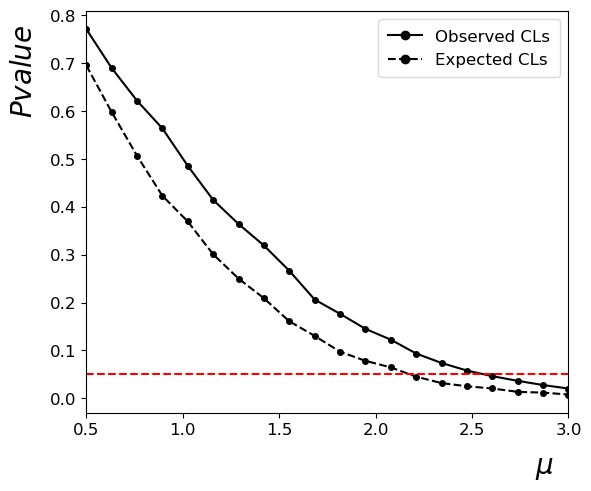

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(mu,Op_value,color='k',marker='o',label='Observed CLs')
ax.plot(mu,Ep_value,'--',color='k',marker='o',label='Expected CLs')

ax.axhline(y=0.05,ls='--',color='r')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.1)
ax.set_xlim(mu[0],mu[-1])

# Label Y
ax.set_ylabel(r'$Pvalue$')
ax.yaxis.set_label_coords(-0.1,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('UpperLimit_Scan.pdf')

In [22]:
# Distribution

In [23]:
Qobs = GetObsJointLnQ(GetLnQ,ObservedLimit,Expected=False)
q0,q1 =  Sampler(ObservedLimit)

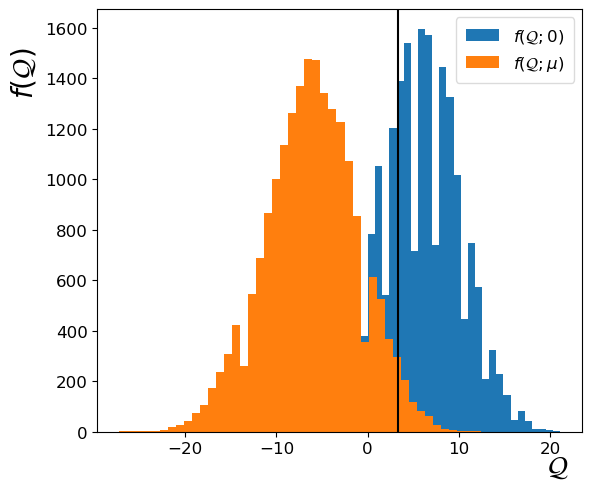

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=45,label=r'$f(\mathcal{Q};0)$')
ax.hist(q1,bins=45,label=r'$f(\mathcal{Q};\mu)$')
ax.axvline(x=Qobs,color='k')

# Label X
ax.set_xlabel(r'$\mathcal{Q}$')
ax.xaxis.set_label_coords(0.95,-0.05)

# Label Y
ax.set_ylabel(r'$f(\mathcal{Q})$')
ax.yaxis.set_label_coords(-0.12,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('Distribution_Q.pdf')